In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv


In this project we are going to train a ML model to detect fake news based on Recurrent Neural Network. We will explot "Natural Language Processing (NLP)" to convert text into numbers. Theses numbers are then fed to train ML model (LSTM) for predicting the authenticity of news. The tasks performed in this project are:
* Exploratory data analysis
* Data cleaning
* Visualize datasets
* Prepare the data by performing tokenization and padding
* Train an LSTM Model
* Evaluate trained model performance

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#Now keras libraries
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [3]:
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [4]:
fake_df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
true_df

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [6]:
# Check null values True
true_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
# Check null values of False
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
# If we also want to know the memory usage
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [9]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


## Exploratory Data Analysis

* Feature Engineering

In [10]:
# Now lets add an target column for indicating real and fake news
true_df['isfake'] = 0
fake_df['isfake'] = 1

In [11]:
true_df.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [12]:
fake_df.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [13]:
#Now lets concatenate both of them
df = pd.concat([true_df, fake_df]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


In [14]:
# Drop the date column
df.drop(columns= ['date'], axis =1, inplace= True)
df

,title,text,subject,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0
...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1


In [15]:
# Combine "title" and "text" in single column
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...


In [16]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

* Data Cleaning

In [17]:
# Add some additional stopwors in nltk stopwords package
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [18]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
# To remove stopwords and words with length less than 3
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >3 and token not in stop_words:
            result.append(token)
    return result

In [20]:
# Now lets apply the defined function of "original" text in our datadrame
df['clean'] = df['original'].apply(preprocess)

In [21]:
df

,title,text,subject,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal..."


In [22]:
# original news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [23]:
# clean news after removing stopwords
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [24]:
# Total number of words in dataset
list_words = []
for i in df.clean:
    for j in i:
        list_words.append(j)
print ('Total number of words are: {}'.format(len(list_words)))

Total number of words are: 9276947


In [25]:
#list_words

In [26]:
#total unique words
total_unique_words = len(list(set(list_words)))
total_unique_words

108704

In [27]:
# Now lets convert words in "clean" column to a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,1,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,1,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


Lets visualize one sample of each join_cleaned, cleaned and original column

In [28]:
df['clean_joined'][1]

'military accept transgender recruits monday pentagon washington reuters transgender people allowed time enlist military starting monday ordered federal courts pentagon said friday president donald trump administration decided appeal rulings blocked transgender federal appeals courts washington virginia week rejected administration request hold orders lower court judges requiring military begin accepting transgender recruits justice department official said administration challenge rulings department defense announced releasing independent study issues coming weeks litigate interim appeal occurs administration decided wait study continue defend president lawful authority district court meantime official said speaking condition anonymity september pentagon said created panel senior officials study implement directive trump prohibit transgender individuals serving defense department submit plan trump lawyers representing currently serving transgender service members aspiring recruits sai

In [29]:
print (df['clean'][1])

['military', 'accept', 'transgender', 'recruits', 'monday', 'pentagon', 'washington', 'reuters', 'transgender', 'people', 'allowed', 'time', 'enlist', 'military', 'starting', 'monday', 'ordered', 'federal', 'courts', 'pentagon', 'said', 'friday', 'president', 'donald', 'trump', 'administration', 'decided', 'appeal', 'rulings', 'blocked', 'transgender', 'federal', 'appeals', 'courts', 'washington', 'virginia', 'week', 'rejected', 'administration', 'request', 'hold', 'orders', 'lower', 'court', 'judges', 'requiring', 'military', 'begin', 'accepting', 'transgender', 'recruits', 'justice', 'department', 'official', 'said', 'administration', 'challenge', 'rulings', 'department', 'defense', 'announced', 'releasing', 'independent', 'study', 'issues', 'coming', 'weeks', 'litigate', 'interim', 'appeal', 'occurs', 'administration', 'decided', 'wait', 'study', 'continue', 'defend', 'president', 'lawful', 'authority', 'district', 'court', 'meantime', 'official', 'said', 'speaking', 'condition', 'a

In [30]:
print (df['original'][1])

U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District C

Now its time to visualize the pre-processed dataset using some advance tools.

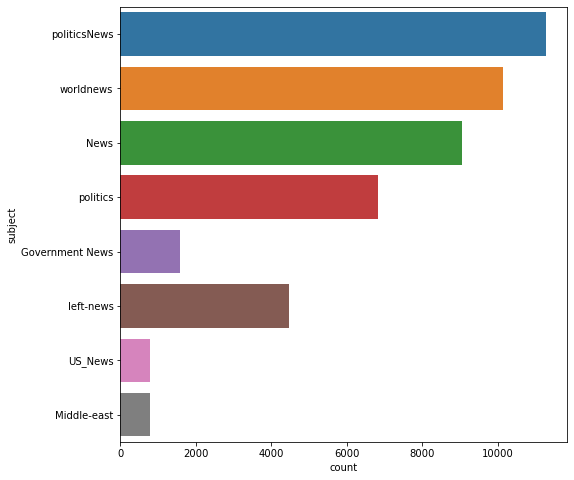

In [31]:
# First, lets plot the num of samples in subject 
plt.figure(figsize=(8,8))
sns.countplot(y = 'subject', data = df)

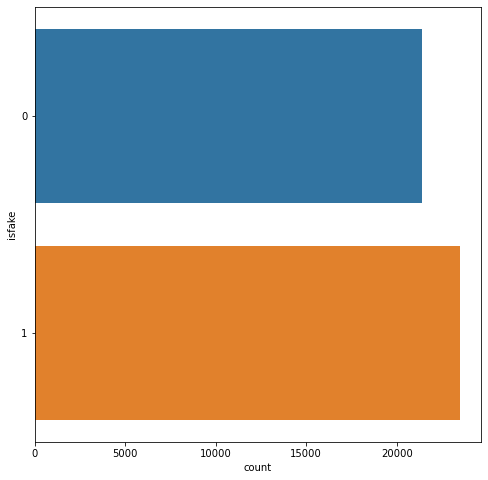

In [32]:
# fake vs true news
plt.figure(figsize=(8,8))
sns.countplot(y = 'isfake', data = df)

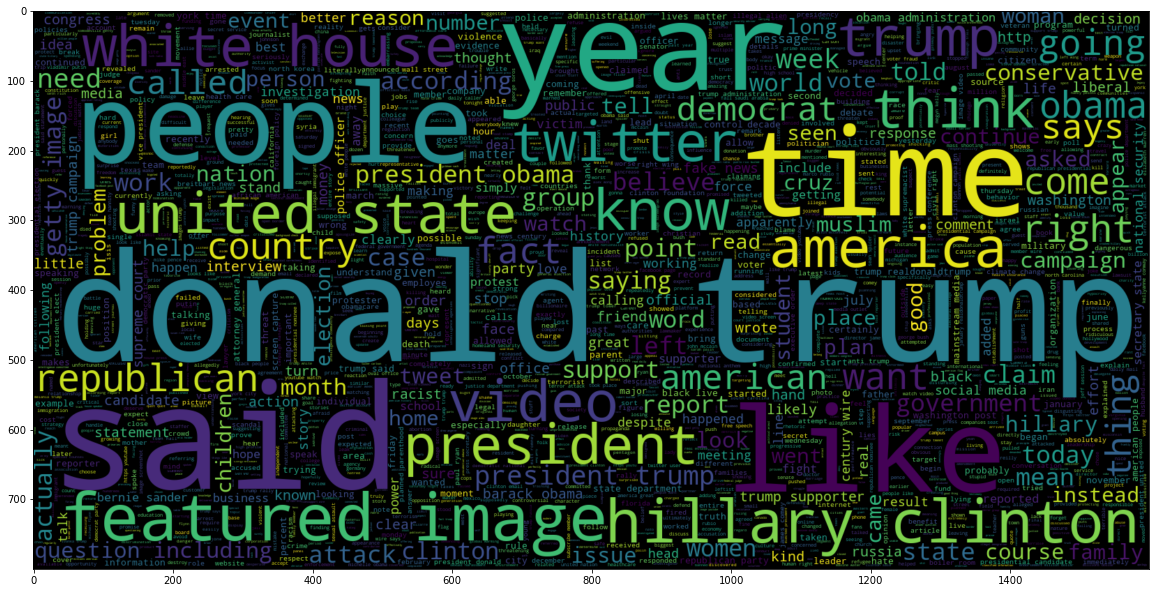

In [33]:
# Now lets plot word cloud for Real news. This will show the most common words when the news is Fake.
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800, stopwords= stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation= 'bilinear')

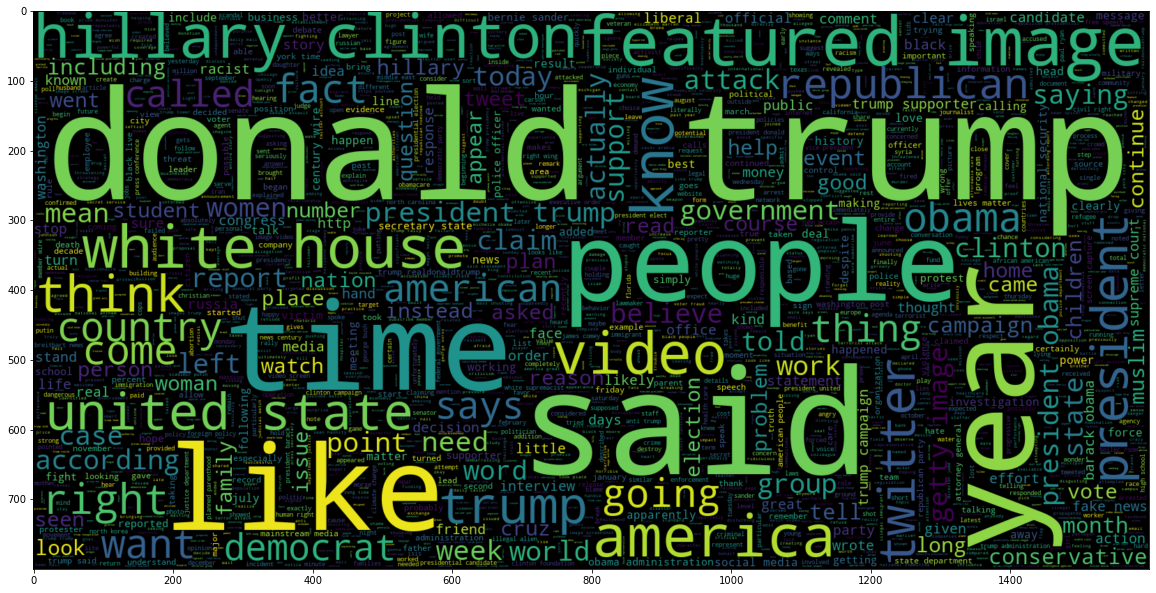

In [34]:
# Now lets plot word cloud for Real news. This will show the most common words when the news is Fake.
# As most new are Political, so words are clearly visible in these plots.
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800, stopwords= stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation= 'bilinear')

In [35]:
# Now maximum length is required to create word embeddings
maxlen = -1
for news in df.clean_joined:
    tokens = nltk.word_tokenize(news) #converts text to tokens (words)
    if (maxlen < len(tokens)):
        maxlen = len(tokens)
print ("The maximum number of words in any news is =", maxlen)

The maximum number of words in any news is = 4405


In [36]:
#Now lets visualize the distribution of number of words in a text, using a very interactive tool "Plotly"
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

Now we will perform **Tokenization** and **Padding**

## **Tokenizer:** It allow us to covert text corpus into a sequence of integers.

In [37]:
# Split data into Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2, random_state = 42)

In [38]:
from nltk import word_tokenize

## To understand about "Keras Tokenizer" and the following commands in a more ellaborative way, please click [here](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do)

In [39]:
# Lets create tokenizer to tokenize the words and conert them into a sequence
tokenizer = Tokenizer(num_words= total_unique_words)
tokenizer.fit_on_texts(x_train) #It creates vocabulary index ("word_index") based on word frequency
train_sequences = tokenizer.texts_to_sequences(x_train) # Replace each word in text with corresponding integer value from "word_index"
test_sequences = tokenizer.texts_to_sequences(x_test)

In [40]:
len(train_sequences)

35918

In [41]:
len(test_sequences)

8980

In [42]:
print ("The encoding for news\n", df.clean_joined[0], "\n is\n :", train_sequences[0])

The encoding for news
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying 

## Now we need to apply padding to make sure that all the sequences have same length.

In [43]:
pad_train = pad_sequences(train_sequences, maxlen = 4405, padding = 'post', truncating= 'post')
pad_test = pad_sequences(test_sequences, maxlen=4405, padding = 'post', truncating= 'post')

In [44]:
# Lets visualize the padding sequence for 1st two samples
for i, news in enumerate(pad_train[:2]):
    print("The padded encoding for news", i+1, " is : ", news)

The padded encoding for news 1  is :  [ 24 969 970 ...   0   0   0]
The padded encoding for news 2  is :  [139 160 457 ...   0   0   0]


In [45]:
# Lets visualize the padding sequence for 1st two samples
for i, news in enumerate(pad_test[:2]):
    print("The padded encoding for news", i+1, " is : ", news)

The padded encoding for news 1  is :  [ 858  371 3238 ...    0    0    0]
The padded encoding for news 2  is :  [ 438  386 7102 ...    0    0    0]


## Recurrent Neural Networks (RNN)

* The major drawback of ANN is that they don't have time dependency or memory effect.
* RNN considers the temporal dimension and possess internal memory state.
* However, RNN suffers from ***Vanishing Gradient*** problem just like ANN. It fails to establish long term dependencies.

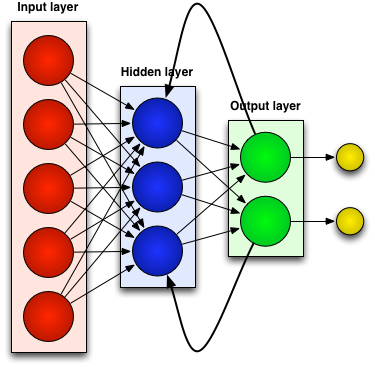

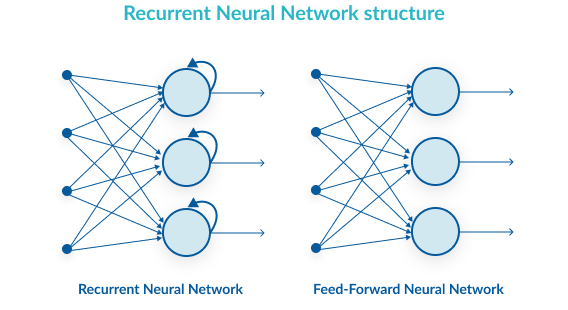Difference btw ANN & RNN

## Long Short Term Memory (LSTM)Networks

* LSTM works better as compared to RNN because it solves the vanishing gradient problem. All RNNs have feedback loops in the recurrent layer. This lets them maintain information in 'memory' over time. But, it can be difficult to train standard RNNs to solve problems that require learning long-term temporal dependencies. This is because the gradient of the loss function decays exponentially with time (called the vanishing gradient problem). LSTM networks are a type of RNN that uses special units in addition to standard units. LSTM units include a 'memory cell' that can maintain information in memory for long periods of time. A set of gates is used to control when information enters the memory, when it's output, and when it's forgotten. This architecture lets them learn longer-term dependencies. GRUs are similar to LSTMs, but use a simplified structure. They also use a set of gates to control the flow of information, but they don't use separate memory cells, and they use fewer gates. [Source](https://stats.stackexchange.com/questions/222584/difference-between-feedback-rnn-and-lstm-gru)

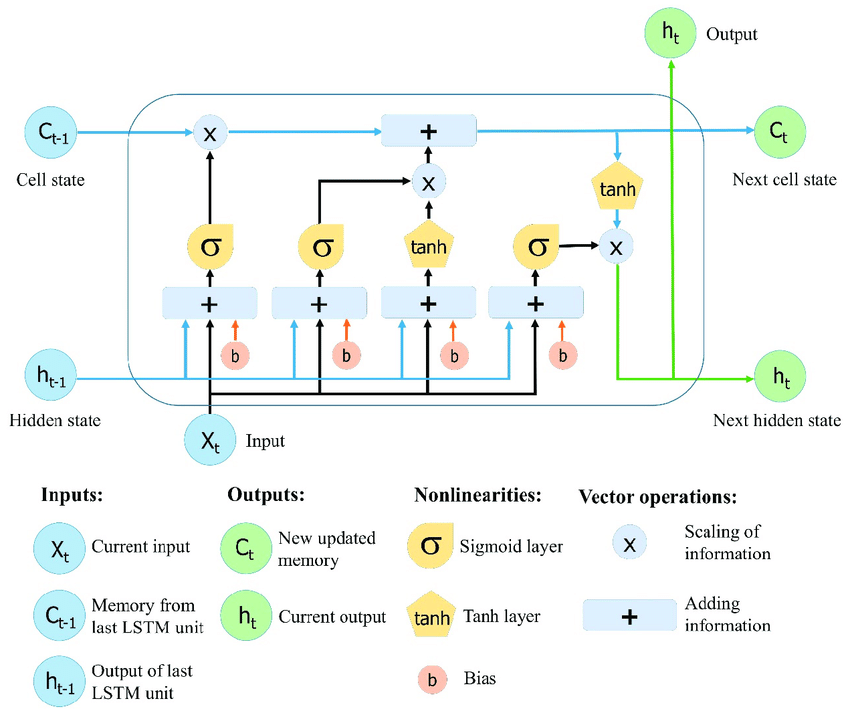

## Embedding Layers
* Embedding layers learn the low dimensional continuous representation of input discrete variables.
* Embedding layers can learn the ways to represent 10,000 variables with 200 variables (Just like PCA and Auto-encoders)
* Thus subsequent layer learn more efficiently with less compute resources.

In [46]:
# Now lets build the model
model = Sequential() 

model.add(Embedding(total_unique_words, output_dim = 128)) #Embedding Layer

model.add(Bidirectional(LSTM(128))) #Bi-directional LSTM

#Dense layer
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) # binary classification (0\1)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         13914112  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_train = np.asarray(y_train)

In [48]:
# train the model
model.fit(pad_train, y_train, batch_size= 64, validation_split = 0.1, epochs= 2)

Epoch 1/2
506/506 [==============================] - 347s 687ms/step - loss: 0.0443 - acc: 0.9820 - val_loss: 0.0058 - val_acc: 0.9983
Epoch 2/2
506/506 [==============================] - 351s 693ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0039 - val_acc: 0.9992


## Assess Trained Model Performance

In [49]:
pred = model.predict(pad_test) #prediction

In [50]:
# Lets set the threshold 0.5, i.e if pred >0.5, it implies the news is fake and vice versa.
prediction = []
for i in range (len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [51]:
#accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print ("The model accuracy is :", accuracy)

The model accuracy is : 0.9984409799554566


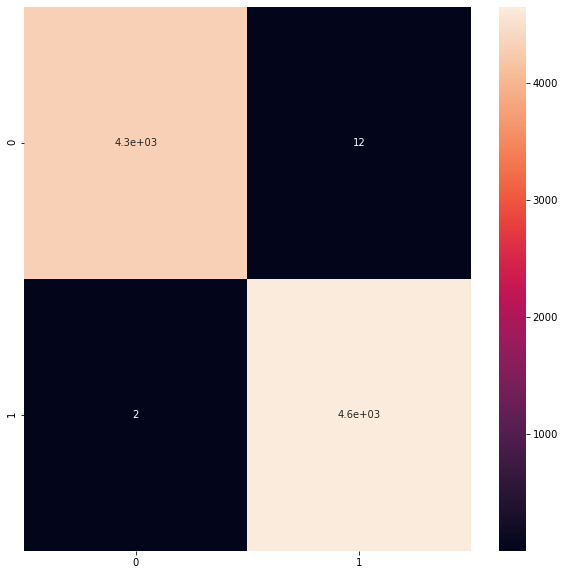

In [52]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot = True)

## Acknowledgment

I am thankful to [Coursera](https://www.coursera.org/learn/nlp-fake-news-detector) and [Ryan Ahmad](https://www.coursera.org/instructor/~48777395) for providing an amazing opportunity for improving NLP skills.